In [ ]:
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy import inspect
from sqlalchemy import text
import os
import geopandas as gpd

ModuleNotFoundError: No module named 'matplotlib.plot'

In [5]:
host = 'localhost'
database = 'spatial'
user = 'postgres'
port = '5432'
password = os.getenv('SQL_PASSWORD')

In [6]:
connection_string = f"postgresql://{user}:{password}@{host}:{port}/{database}"

In [7]:
engine = create_engine(connection_string)
insp = inspect(engine)
insp.get_table_names()

['spatial_ref_sys']

## Streets in MA

<Axes: >

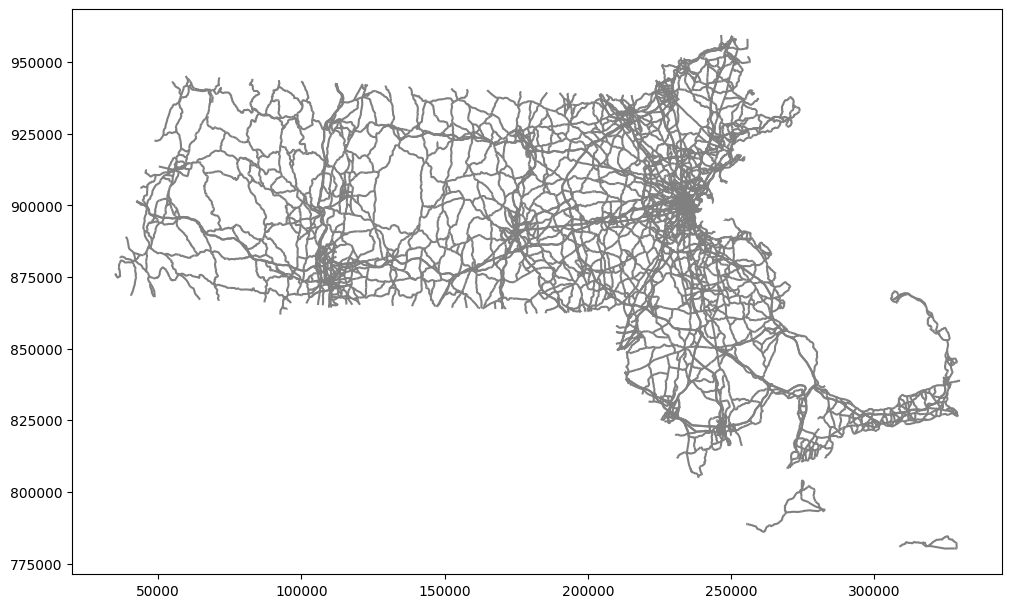

In [47]:
text_road = """ SELECT * FROM ch09.road"""
road = gpd.read_postgis(text_road, con=engine)

fig, ax = plt.subplots(figsize=(12, 10))
road.plot(ax=ax, color = 'grey')

## Parcel

<Axes: >

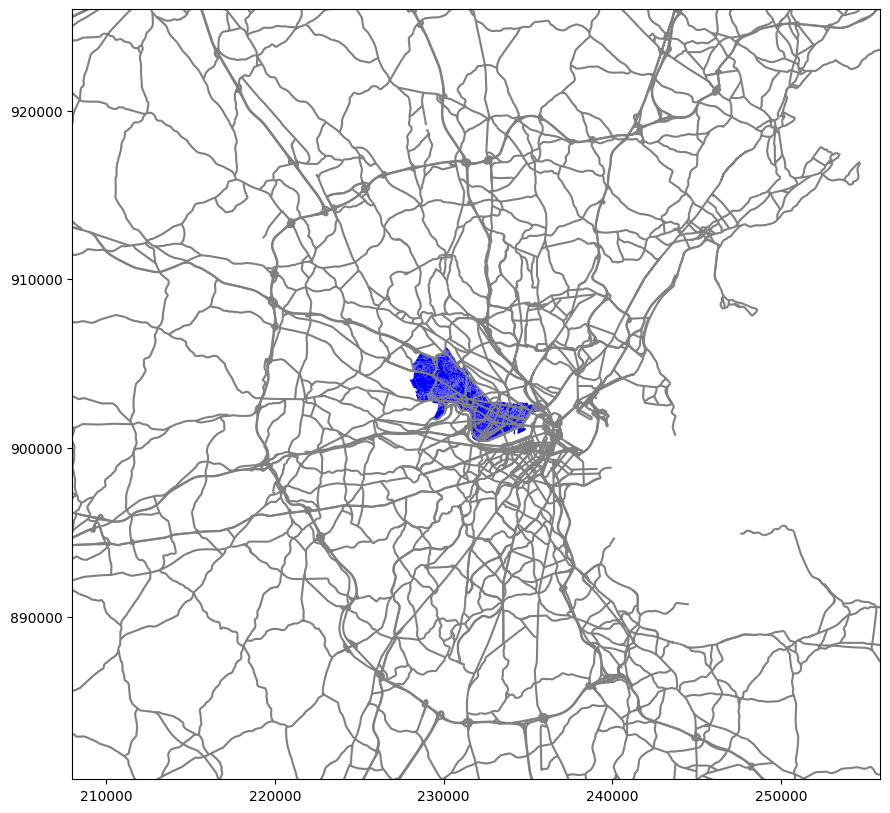

In [51]:
text_road = """ SELECT * FROM ch09.road"""
road = gpd.read_postgis(text_road, con=engine)

text_land = """ SELECT * FROM ch09.land"""
land = gpd.read_postgis(text_land, con=engine)
# Get bounding box of land to zoom in
xmin, ymin, xmax, ymax = land.total_bounds

fig, ax = plt.subplots(figsize=(12, 10))
buffer = 20000
ax.set_xlim(xmin -  buffer, xmax + buffer)
ax.set_ylim(ymin - buffer, ymax + buffer)

land.plot(ax=ax, color = 'blue')
road.plot(ax=ax, color = 'grey')

## Snap points on the road to Parcel

               parcel                    road                           geom
0  31R COMMERCIAL AVE  EDWIN H LAND BOULEVARD  POINT (234897.485 901845.111)
1        1 CHARLES PK  EDWIN H LAND BOULEVARD  POINT (234892.075 901845.949)
2     727 MEMORIAL DR          MEMORIAL DRIVE    POINT (231719.71 900829.21)
3     767 MEMORIAL DR          MEMORIAL DRIVE  POINT (231684.984 900963.475)
4     187 MAGAZINE ST          MEMORIAL DRIVE  POINT (231761.486 900758.649)


<Axes: >

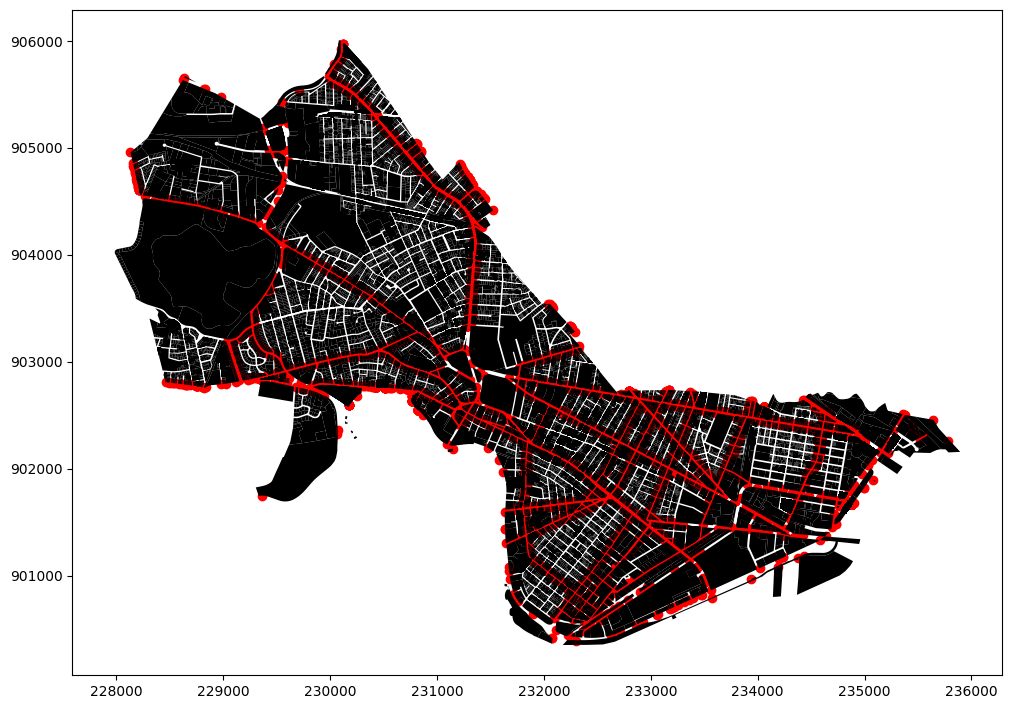

In [53]:
text_snap_point= """SELECT DISTINCT ON (land.pid)
land.addr_num || ' ' || full_str AS parcel,
road.road_name AS road,
ST_ClosestPoint(land.geom,road.geom) As geom

FROM ch09.land AS land INNER JOIN ch09.road AS road
ON ST_DWithin(land.geom,road.geom,20.0)
ORDER BY land.pid, ST_Distance(land.geom,road.geom);"""

snap_point = gpd.read_postgis(text_snap_point, con=engine)

print(snap_point.head(n = 5))

text_land = """ SELECT * FROM ch09.land"""
land = gpd.read_postgis(text_land, con=engine)
fig, ax = plt.subplots(figsize=(12, 10))

snap_point.plot(ax=ax, color = 'red')
land.plot(ax=ax, color = 'black')

## Clustering: k_means

<Axes: >

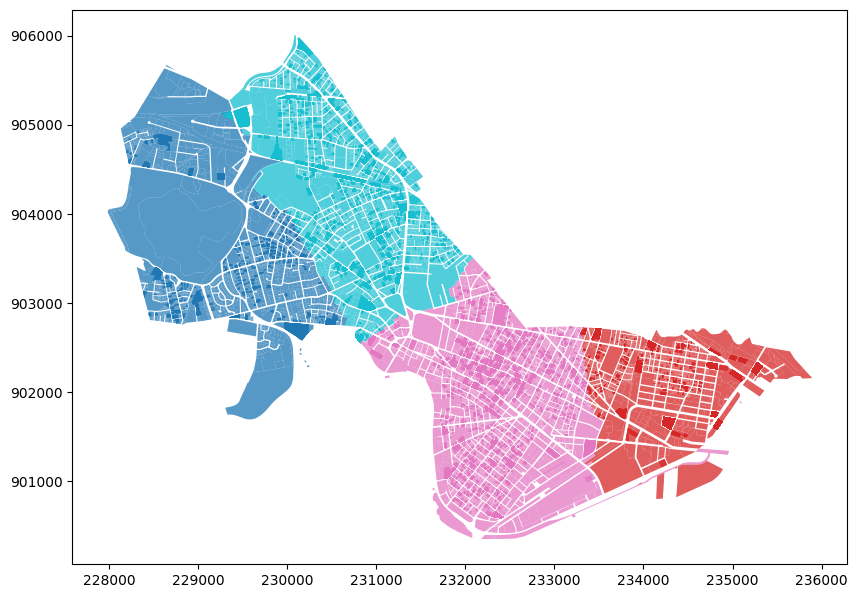

In [72]:
text_cluster = """SELECT land.pid, land.geom,
land.addr_num || ' ' || full_str AS address,
ST_ClusterKMeans(land.geom, 4) OVER() AS kcluster,
ST_ClusterDBSCAN(land.geom, 15, 2) OVER() AS dcluster
FROM ch09.land AS land;"""

cluster = gpd.read_postgis(text_cluster, con = engine)

# Plot the clusters based on kcluster column
fig, ax = plt.subplots(figsize=(10, 8))
cluster.plot(column="kcluster", cmap="tab10", edgecolor="none", alpha=0.75, ax=ax)

## DBScan clustering

<Axes: >

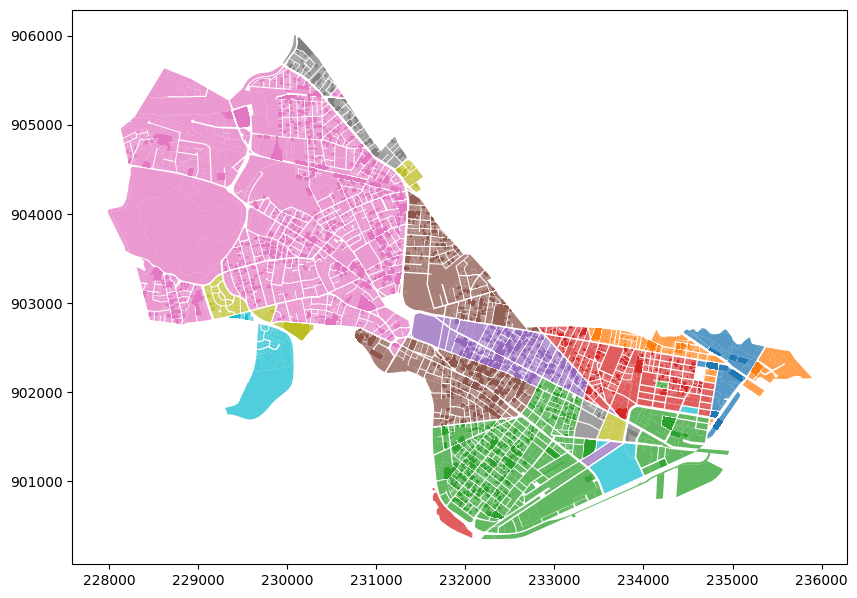

In [66]:
# Plot the clusters based on kcluster column
fig, ax = plt.subplots(figsize=(10, 8))
cluster.plot(column="dcluster", cmap="tab10", edgecolor="none", alpha=0.75, ax=ax)